# Time series analysis
## Task 6
### Importing data

In [2]:
import datetime
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import mean_absolute_percentage_error
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR,LinearSVR

import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.deterministic import DeterministicProcess
from statsmodels.tsa.seasonal import seasonal_decompose
plt.style.use("seaborn-v0_8")

import warnings
warnings.filterwarnings("ignore")

In [3]:
#import of table
df = pd.read_csv('C:/Users/droni/Documents/Ulikool MASM/1 sem/ITS8080 Andmed/253253MASM/train_253253.csv',  delimiter=',',decimal='.', index_col = False)

df['timestamp'] = pd.to_datetime(df['timestamp'])   # convert column to datetime
df = df.set_index('timestamp') 
df = df.asfreq("h") 
df.head()

demando = df[['Demand']]


In [4]:
#info about demand
df['Demand'] = pd.to_numeric(df['Demand'], errors='coerce')
print("Rows:", len(df))
print(df['Demand'].describe())

Rows: 8760
count    8759.000000
mean        0.530993
std         0.375317
min         0.000000
25%         0.280000
50%         0.380000
75%         0.660000
max         4.240000
Name: Demand, dtype: float64


## Task 6.1

In [6]:
#prepare for decomposition
#no NaN needed and inerpolation
df['Demand_interp'] = df['Demand'].interpolate(method='time', limit=24)
df['Demand_interp'] = df['Demand_interp'].fillna(method='ffill').fillna(method='bfill')

# cheacking frequency, must be hourly
median_diff = (df.index.to_series().diff().median())
print("Median index difference:", median_diff)

Median index difference: 0 days 01:00:00


<Figure size 1000x300 with 0 Axes>

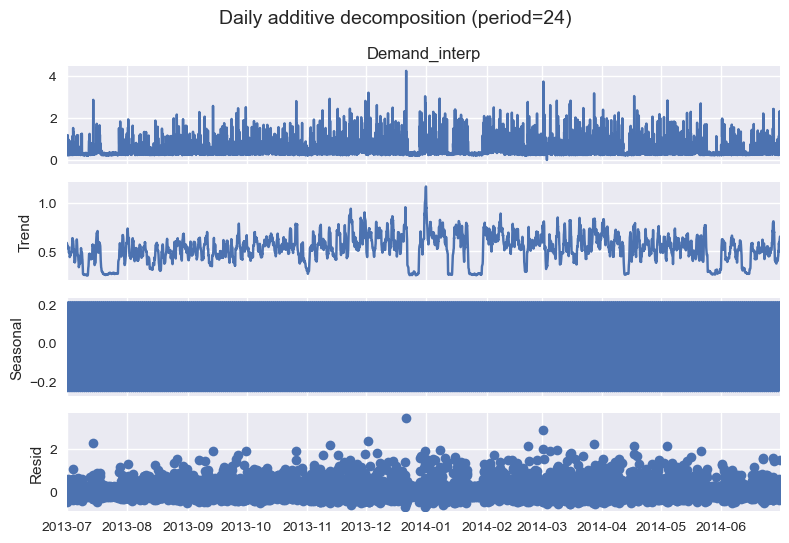

In [7]:
#Classical additive decomposition
#different periods
period_daily = 24
period_weekly = 24*7
period_monthly = int(24*30.4)
period_sesonaly = 24*90

#daily decomp
decomp_daily = seasonal_decompose(df['Demand_interp'], period=period_daily, model='additive', extrapolate_trend='freq')
plt.figure(figsize=(10,3))
decomp_daily.plot()
plt.suptitle("Daily additive decomposition (period=24)", fontsize=14)
plt.tight_layout()
plt.show()
#needed

<Figure size 1000x300 with 0 Axes>

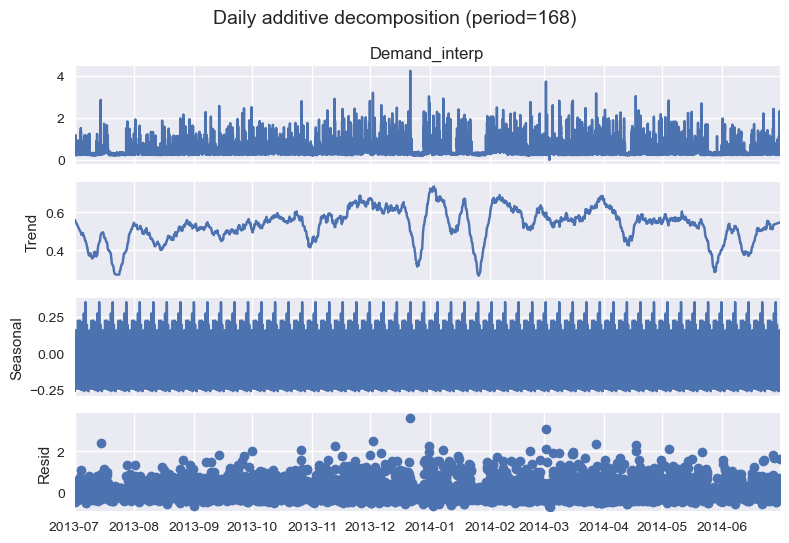

In [8]:
#weekly decomp
decomp_weekly = seasonal_decompose(df['Demand_interp'], period=period_weekly, model='additive', extrapolate_trend='freq')
plt.figure(figsize=(10,3))
decomp_weekly.plot()
plt.suptitle("Daily additive decomposition (period=168)", fontsize=14)
plt.tight_layout()
plt.show()
#needed

<Figure size 1000x300 with 0 Axes>

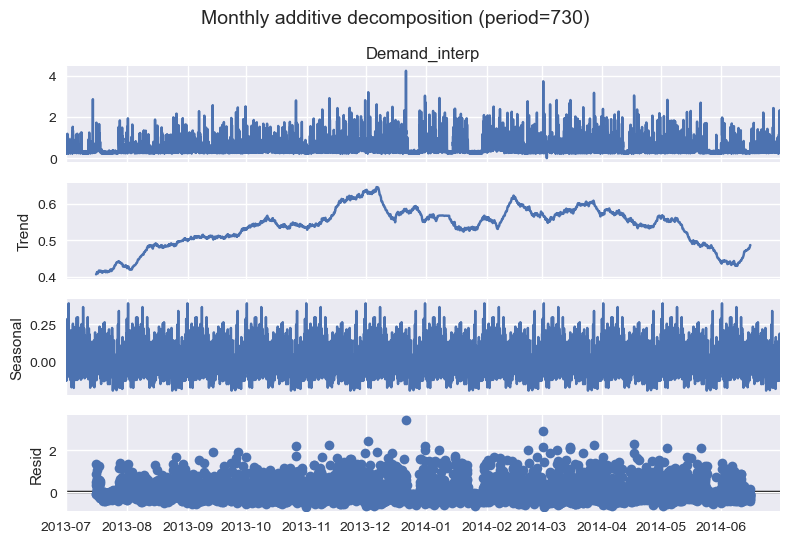

In [9]:
#monthly decomp
decomp_monthly = seasonal_decompose(df['Demand_interp'], period=period_monthly, model='additive')

plt.figure(figsize=(10,3))
decomp_monthly.plot()
plt.suptitle("Monthly additive decomposition (period=730)", fontsize=14)
plt.tight_layout()
plt.show()
#needed

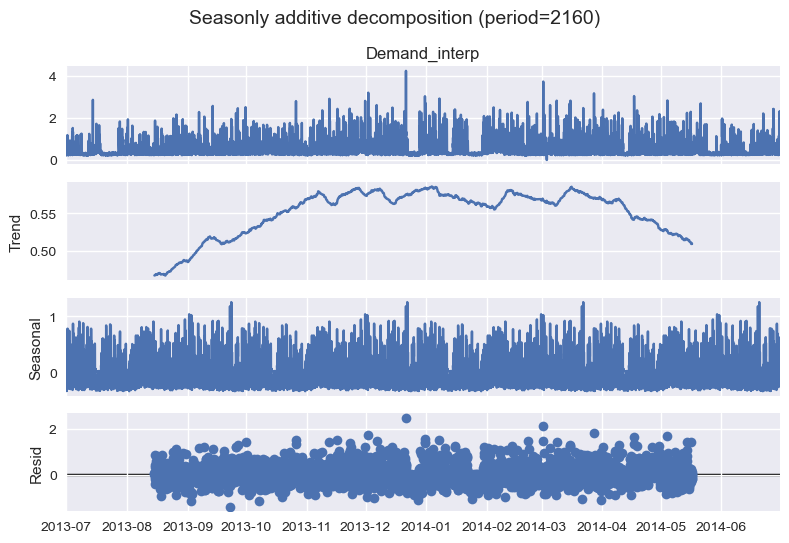

In [10]:
# quaterly decomp
decomp_sesonaly = seasonal_decompose(df['Demand_interp'], period=period_sesonaly, model='additive')

decomp_sesonaly.plot()
plt.suptitle("Seasonly additive decomposition (period=2160)", fontsize=14)
plt.tight_layout()
plt.show()
#needed

In [11]:
#separatly deomposion's parts
trend_daily = decomp_daily.trend
seasonal_daily = decomp_daily.seasonal
resid_daily = decomp_daily.resid

trend_weekly = decomp_weekly.trend
seasonal_weekly = decomp_weekly.seasonal
resid_weekly = decomp_weekly.resid

# # cheacking sum satistic components
components_summary = pd.DataFrame({
    'original_mean': [df['Demand_interp'].mean()],
    'trend_mean_daily': [trend_daily.mean()],
    'seasonal_std_daily': [seasonal_daily.std()],
    'resid_std_daily': [resid_daily.std()],
})
print(components_summary.T)

                           0
original_mean       0.531020
trend_mean_daily    0.531102
seasonal_std_daily  0.154748
resid_std_daily     0.309419


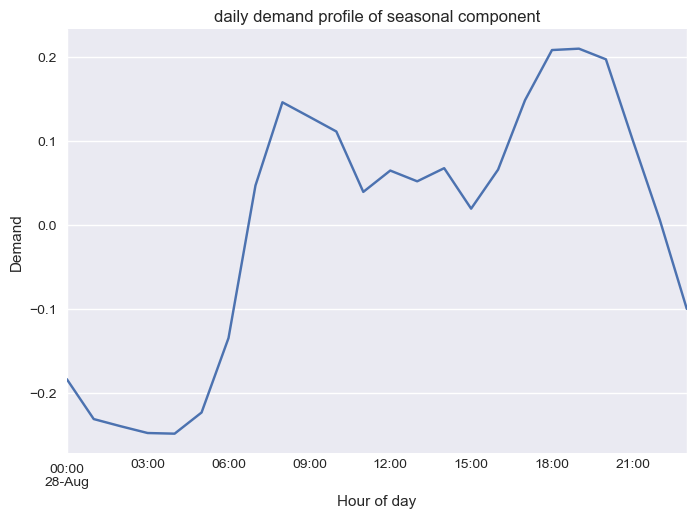

In [14]:
#season component
daily_aver = decomp_daily.seasonal.loc["2013-08-28":"2013-08-28"]
daily_aver.plot()
plt.title("daily demand profile of seasonal component")
plt.xlabel("Hour of day")
plt.ylabel("Demand")
plt.grid(True)
plt.show()

## Task 6.2

In [17]:
#finding seasonal effect by substracting season comp from standart deamnd value
df['trend_daily'] = decomp_daily.trend

df['intra_day_variation'] = (df['Demand_interp'] - df['trend_daily']).abs()

daily_seasonal_strength = (df['intra_day_variation'].groupby(df.index.date).mean())

daily_seasonal_strength = pd.Series(daily_seasonal_strength, index=pd.to_datetime(daily_seasonal_strength.index))

monthly_seasonal_strength = (daily_seasonal_strength.groupby(daily_seasonal_strength.index.month).mean())

monthly_seasonal_strength.index = monthly_seasonal_strength.index.map(lambda m: pd.to_datetime(str(m), format='%m').strftime('%B'))

print(monthly_seasonal_strength)

January      0.221475
February     0.279509
March        0.291389
April        0.257338
May          0.207867
June         0.201131
July         0.138364
August       0.203092
September    0.225403
October      0.232228
November     0.272947
December     0.261818
Name: intra_day_variation, dtype: float64


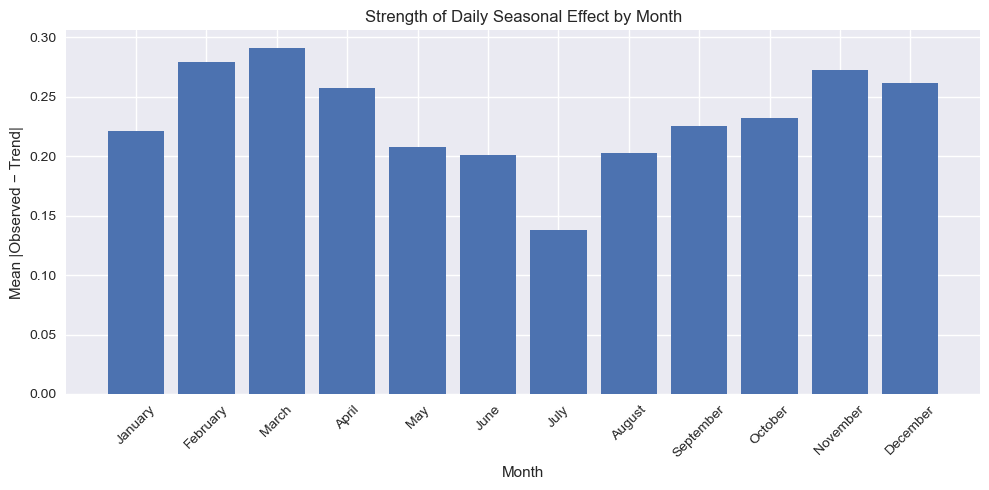

In [18]:
#making plot of that
plt.figure(figsize=(10,5))
plt.bar(
    monthly_seasonal_strength.index,
    monthly_seasonal_strength.values
)
plt.title("Strength of Daily Seasonal Effect by Month")
plt.xlabel("Month")
plt.ylabel("Mean |Observed − Trend|")
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()

## Task 6.3

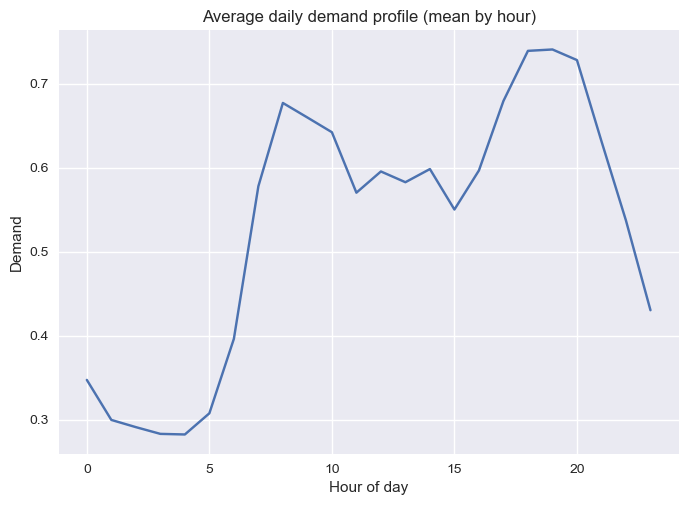

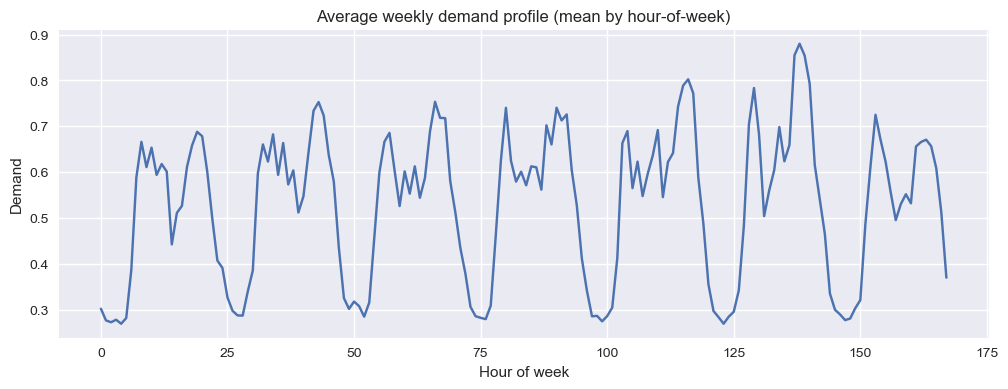

In [19]:
#Average daily profile (mean by hour)
df['hour'] = df.index.hour
avg_daily_profile = df.groupby('hour')['Demand'].mean()
plt.figure()
plt.plot(avg_daily_profile.index, avg_daily_profile.values)
plt.title("Average daily demand profile (mean by hour)")
plt.xlabel("Hour of day")
plt.ylabel("Demand")
plt.grid(True)
plt.show()

#Average weekly profile (mean by hour-of-week)
df['hour_of_week'] = df.index.dayofweek * 24 + df.index.hour
avg_weekly_profile = df.groupby('hour_of_week')['Demand'].mean()
plt.figure(figsize=(12,4))
plt.plot(avg_weekly_profile.index, avg_weekly_profile.values)
plt.title("Average weekly demand profile (mean by hour-of-week)")
plt.xlabel("Hour of week")
plt.ylabel("Demand")
plt.grid(True)
plt.show()


Complete days for clustering: 364


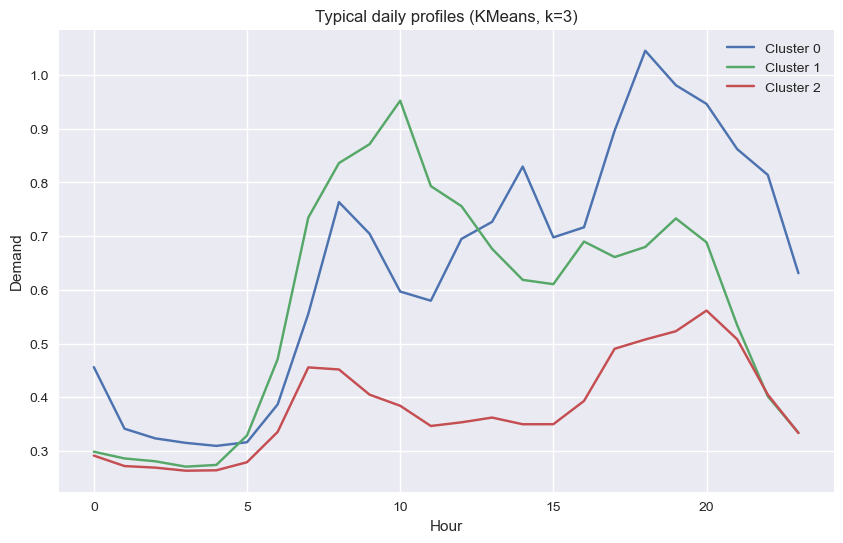

Cluster sizes: Counter({2: 128, 0: 118, 1: 118})


In [22]:
# some clusters by ChatGPT, not used in report, just for reference
#Кластеризация дней для выявления типичных дневных профилей (покажет "типы дней")
# Создадим матрицу: строки = дни, колонки = часы (0..23)
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

tmp = df[['Demand']].copy()
tmp['date'] = tmp.index.date
daily_matrix = tmp.pivot_table(index='date', columns=tmp.index.hour, values='Demand')

# Удаляем неполные дни
daily_matrix = daily_matrix.dropna()
print("\nComplete days for clustering:", len(daily_matrix))

# Нормализация и кластеризация
scaler = StandardScaler()
X = scaler.fit_transform(daily_matrix.values)
k = 3  # можно варьировать
kmeans = KMeans(n_clusters=k, random_state=42)
labels = kmeans.fit_predict(X)
centroids = scaler.inverse_transform(kmeans.cluster_centers_)

# График центроидов (типичных профилей)
plt.figure(figsize=(10,6))
hours = range(24)
for i, c in enumerate(centroids):
    plt.plot(hours, c, label=f'Cluster {i}')
plt.title(f"Typical daily profiles (KMeans, k={k})")
plt.xlabel("Hour")
plt.ylabel("Demand")
plt.legend()
plt.grid(True)
plt.show()

# Сколько дней в кластерах
import collections
print("Cluster sizes:", collections.Counter(labels))

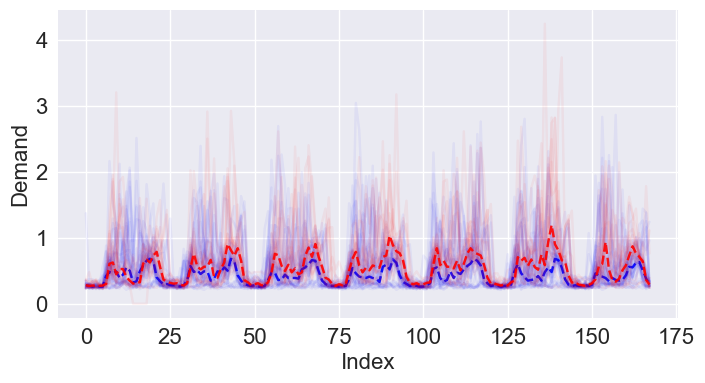

In [27]:
#KMeans approach for clusters
#weekly, like winter and summer weeks
from sklearn.cluster import KMeans

def plot_clusters(data, title, c, f):
    periods = [g for n, g in data.groupby(pd.Grouper(freq = f))]

    for i in range(len(periods)):
        periods[i] = periods[i].rename(str(i))
        periods[i].reset_index(drop=True, inplace=True)

    df = pd.DataFrame(periods)
    df = df.dropna()

    
    kmeans = KMeans(n_clusters=c)
    cluster_found = kmeans.fit_predict(df)
    cluster_values, cluster_counts = np.unique(kmeans.labels_, return_counts=True)


    cluster_found_sr = pd.Series(cluster_found, name='cluster')
    df = df.set_index(cluster_found_sr, append=True )



    fig, ax= plt.subplots(1,1, figsize=(8,4))
    color_list = ['blue','red','green','black','orange','purple', 'cyan']
    color_list = color_list[0:(c)]
   

    
    for cluster, color in zip(cluster_values, color_list):
        df.xs(cluster, level=1).T.plot(
            ax=ax, legend=False, alpha=0.050, color=color, label= f'Cluster {cluster}'
        )
        
        median_centroid=df.xs(cluster, level=1).median()
        
        median_centroid.plot(
            ax=ax, color=color, alpha=0.9, ls='--'
        )
        

    ax.legend()
    plt.xlabel('Index', fontsize=16)
    plt.ylabel('Demand', fontsize=16)
    plt.legend('', frameon=False)
    plt.yticks(fontsize=16)
    plt.xticks(fontsize=16)
    
    return plt;

plot_clusters(demando['Demand'], 'Demand', 2, 'W');

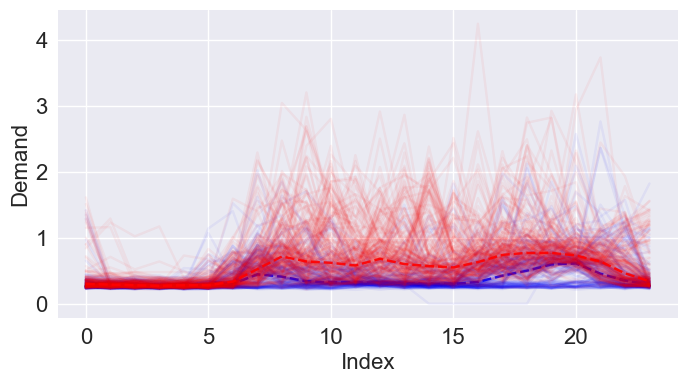

In [25]:
#daily, more like workdays and weekends
plot_clusters(demando['Demand'], 'Consumption', 2, 'D');